CODE BLOCK: 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CPU times: user 974 ms, sys: 164 ms, total: 1.14 s
Wall time: 1.42 s


CODE BLOCK: 2

In [3]:
%%time 

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False
CPU times: user 66 µs, sys: 12 µs, total: 78 µs
Wall time: 84.9 µs


CODE BLOCK: 3

In [4]:
mnist_data = datasets.MNIST(
        root='../data', 
        download=False,        
        transform=transforms.ToTensor()
)

print(mnist_data)
print(f"classes present in mnist= {mnist_data.classes}")
print(f"number of imges in mnist= {len(mnist_data.data)}")



batch_size = 128
kwargs = {'batch_size':batch_size,'shuffle': True, 'num_workers': 2, 'pin_memory': True } if cuda else {'shuffle': True,'batch_size':batch_size}

data_loader = torch.utils.data.DataLoader(
        mnist_data, 
        **kwargs
)

print(f'batch_size= {batch_size}')
print(f'number of images per batch_size {len(mnist_data)/batch_size}')
print(f"number of workers = {data_loader.num_workers}")

print(data_loader)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
classes present in mnist= ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
number of imges in mnist= 60000
batch_size= 128
number of images per batch_size 468.75
number of workers = 0


shape of batch =torch.Size([128, 1, 28, 28])
number of imgs in each batch= 128
shape of img = torch.Size([1, 28, 28])


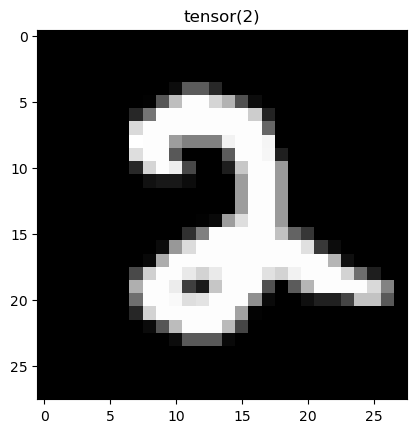

In [5]:
imgs,labels = next(iter(data_loader))
random_number = np.random.choice( int(batch_size) , )

print(f"shape of batch ={imgs.shape}")
print(f"number of imgs in each batch= {len(imgs)}")
print(f"shape of img = {imgs[random_number].shape}")

plt.imshow(imgs[random_number].squeeze(0),  cmap='gray');
plt.title(label=labels[random_number])
plt.show();


In [6]:
imgs[random_number].squeeze(0).shape

torch.Size([28, 28])

In [7]:
imgs[random_number].unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [8]:
from collections import OrderedDict
d= OrderedDict()

for i in labels:
    i = i.item()
    if i not in d:
        d[i]=0
    else:
        d[i]+=1
        
print('class   :number_of_times')
for key, value in d.items():
    print(f"{key}\t:\t{value}")

class   :number_of_times
5	:	23
4	:	16
8	:	13
3	:	19
6	:	10
7	:	10
9	:	5
2	:	12
1	:	6
0	:	4


In [9]:
mean = 0.0
std = 0.0
total_images = 0
number_of_batch = 0

for idx,(images,label)  in enumerate(data_loader,1):
    number_of_batch = idx
    batch_size = images.size(0)
    
    images = images.view(batch_size, -1)      # images.view(  128, -1  )  # flattern all pixel values so 128 images/rows
    mean += images.mean(1).sum()              # mean value per batch
    std += images.std(1).sum()                # std value per batch
    total_images += batch_size
    
    
mean /= total_images
std /= total_images


print(f'number of batchs = {number_of_batch}')
print(f'mean of whole dataset = {mean}')
print(f'std  of whole dataset = {std}')

number of batchs = 469
mean of whole dataset = 0.1306605488061905
std  of whole dataset = 0.3015042245388031


In [10]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),  # p=probability of picking image to apply crop
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),    # 
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
    ])

CODE BLOCK: 4

In [11]:
train_data = datasets.MNIST('../data', train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=False, transform=test_transforms)

CODE BLOCK: 5

In [12]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True} if cuda else {'batch_size': batch_size, 'shuffle': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

number of images in batch_data 512


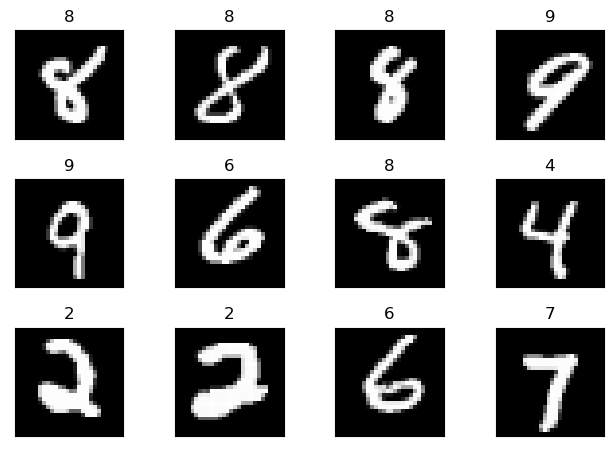

In [13]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 
print(f'number of images in batch_data {batch_data.shape[0]}')

fig = plt.figure()

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(batch_data[i].squeeze(0), cmap='gray')
    plt.title(batch_label[i].item())
    plt.xticks([])
    plt.yticks([])
    
plt.show()

CODE BLOCK: 7

In [14]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,bias=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,bias=False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,bias=False)
        self.fc1 = nn.Linear(4096, 50,bias=False)
        self.fc2 = nn.Linear(50, 10,bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

<img src="./pics/model_architecture.jpg"></img>

Formula
---



$$channel_{out}= {( channel_{in} + (2\times padding) - kernel)\over{stride}} +1 $$

$$j_{out} = j_{in}\times stride$$

$$ rf_{out} = rf_{in} + (kernel-1)\times j_{out}$$



RF calculation
---


| **NAME** | channel_in  | channel_out | r_in | r_out | j_in | j_out | P | S | K | Param # |
|----------|-------------|-------------|------|-------|------|-------|---|---|---|---------|
|  Conv1   |     28      |   26        | 1    | 3     | 1    | 1     | 0 | 1 | 3 | 3 * 3 * 32  |
|  Conv2   |    26       |      24     | 3    | 5     | 1    | 1     | 0 | 1 | 3 | (3 * 3 * 26) * 64 |
|  MaxPool |     24      |     12      | 5    | 6     | 1    | 2     |0  | 2 | 2 |  Nil |
|  Conv3   |     12      |   10        | 6    |10     | 2    | 2     |0  | 1 | 3 | (3 * 3 * 64) * 128 |
|  Conv4   |     10      |   8         |  10  | 14    | 2    | 2     |0  | 1 | 3 | (3 * 3 * 128 ) * 256 |
|  Maxpool |      8      |   4         |  14  | 16    |  2   |  4    |0  | 2 | 2 | Nil |


let's Assume ```bias=False```

In [15]:
device = torch.device("cuda" if cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


In [16]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=4096, out_features=50, bias=False)
  (fc2): Linear(in_features=50, out_features=10, bias=False)
)

In [17]:
for name,weights in model.named_parameters():
    print(f"{name}\t\t {weights.shape}")

conv1.weight		 torch.Size([32, 1, 3, 3])
conv2.weight		 torch.Size([64, 32, 3, 3])
conv3.weight		 torch.Size([128, 64, 3, 3])
conv4.weight		 torch.Size([256, 128, 3, 3])
fc1.weight		 torch.Size([50, 4096])
fc2.weight		 torch.Size([10, 50])


In [18]:
class Net2(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,bias=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,bias=True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,bias=True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,bias=True)
        self.fc1 = nn.Linear(4096, 50,bias=True)
        self.fc2 = nn.Linear(50, 10,bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [19]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [20]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
    
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

        train_acc.append(100*correct/processed)
        train_losses.append(train_loss/len(train_loader))

        
        
def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.2739 Batch_id=19 Accuracy=15.86: 100%|██████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


Test set: Average loss: 2.2752, Accuracy: 16964/60000 (28.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=1.7745 Batch_id=19 Accuracy=43.25: 100%|██████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Test set: Average loss: 1.7100, Accuracy: 39432/60000 (65.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=2.2951 Batch_id=19 Accuracy=40.91: 100%|██████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


Test set: Average loss: 2.2935, Accuracy: 8908/60000 (14.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=2.2492 Batch_id=19 Accuracy=20.10: 100%|██████████████████████████████████| 20/20 [00:30<00:00,  1.54s/it]


Test set: Average loss: 2.2516, Accuracy: 12753/60000 (21.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=1.9419 Batch_id=19 Accuracy=21.74: 100%|██████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Test set: Average loss: 1.9613, Accuracy: 19721/60000 (32.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=1.4964 Batch_id=19 Accuracy=54.79: 100%|██████████████████████████████████| 20/20 [00:28<00:00,  1.40s/it]


Test set: Average loss: 2.0503, Accuracy: 33255/60000 (55.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.2658 Batch_id=1 Accuracy=62.50:   5%|█▊                                  | 1/20 [00:02<00:23,  1.26s/it]

`key takeaway`:
    
- MNIST is solvable with high accuracy in around 2900 Params
- We overkill with our Params
- 

CODE BLOCK: 11

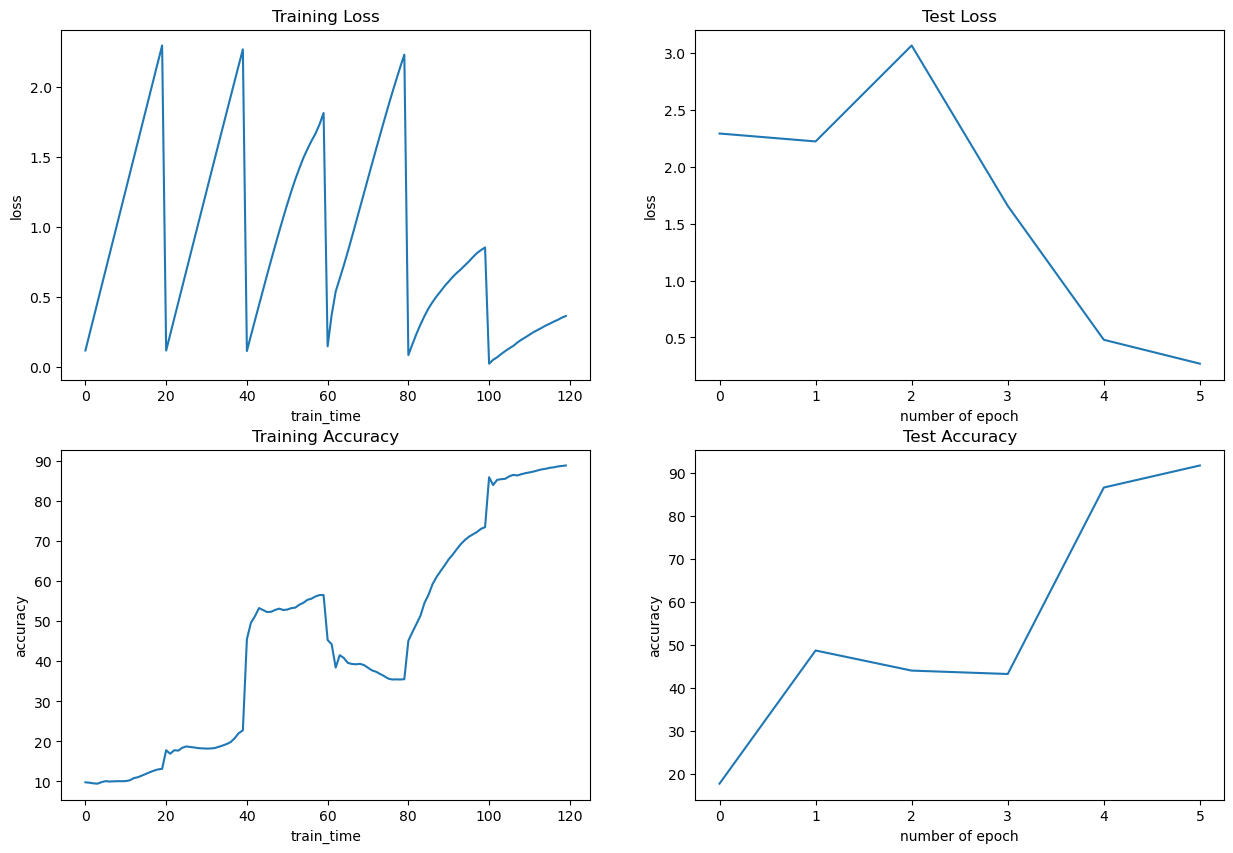

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel('train_time')           # num_epochs * len(train_loader)
axs[0, 0].set_ylabel('loss')

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel('train_time')            # num_epochs * len(train_loader)
axs[1, 0].set_ylabel('accuracy')


axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[0, 1].set_xlabel('number of epoch')
axs[0, 1].set_ylabel('loss')


axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].set_xlabel('number of epoch')
axs[1, 1].set_ylabel('accuracy')
plt.show()